In [45]:
# python -m notebook --ip=0.0.0.0 --no-browser --NotebookApp.allow_origin='*'
# ssh  mac9908@sporcsubmit.rc.rit.edu -L 8888:clx-a-01.rc.rit.edu:8888
import datasets
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
palette = {'CLARA':"#9b59b6", 'AGM(L)':"#3498db", 'AGM(L+E)':"#95a5a6"}
# spack load py-pip/ylgeevx
class ClaraAnalysis():
  def __init__(self) -> None:
     self.dataset_dir = 'dataset'
     self.techniques = {0: 'CLARA', 1: 'AGM(L)', 3: 'AGM(L+E)'}
     self.dataset = datasets.load_from_disk(self.dataset_dir)
     self.dataset = self.dataset.map(self.assign_technique)
     self.dataset = self.dataset.map(self.parse_error_output)
     self.dataframe = self.dataset['final'].to_pandas()
     
     # Setting proper types of data  
     self.dataframe['Technique'] = pd.Categorical(self.dataframe['Technique'])
     self.dataframe['Percentage Repaired'] = self.dataframe['Percentage Repaired'].astype(float)

  def parse_error_output(self, x):
    if x['Parse Error'] == 'True':
        return {'Parse Error Output': re.findall(r':([^\(]+)', x['Error Output'].split('\n')[-2])[0]}
    else:
        return {'Parse Error Output': None}
  def assign_technique(self, x):
    x['Technique'] = self.techniques[x['Technique']]
    return x
  def group_analyze(self, column, type=None, filter=None):
    if type is not None:
      self.dataframe[column] = self.dataframe[column].astype(type)
    return self.dataframe.groupby([column])[column].count()
  
  def summary_statistic(self):
    pass
      
  def groups_analyze(self, columns, df=None):
    if df is None:
      df = self.dataframe
    return df.groupby(columns)[columns].count()

#   def parse_error_output(self, x):
#     return {'Parse Error Output': re.findall(r':([^\(]+)', x['Error Output'].split('\n')[-2])[0]}

  def filter_group_analyze(self, column, type=None):
    dt_parse_error = self.dataset.filter(lambda x: x['Parse Error'] == 'True')\
      .map(self.parse_error_output)
    print(self.group_analyze(dt_parse_error['final'].to_pandas(), 'Parse Error Output', type="category"))
  
  def draw_boxplot(self, groups, title='Title', ylabel='YLabel'):
    data = [self.dataframe[grp].astype(float).to_numpy() for grp in groups]
    sns.boxplot(data)

In [2]:
clara = ClaraAnalysis()

Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-fd2e1c5a5e25c631.arrow
Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-515a1cddc7212e42.arrow


clara.dataframe.head()

In [3]:
# Problem Descriptions
clara.dataframe.columns

Index(['Problem', 'First Output', 'Error Output', 'Correct File',
       'Incorrect File', 'Test Available', 'Correct Locs', 'Incorrect Locs',
       'Old Incorrect Locs', 'Correct Exprs', 'Incorrect Exprs',
       'Old Incorrect Exprs', 'Repairs', 'Technique', 'GM Score', 'Locs',
       'Count', 'Structure Mismatch', 'Repair', 'Repair Correct',
       'Parse Error', 'Cost', 'Second Output', 'Match', 'Percentage Repaired',
       'Timeout', 'Parse Error Output'],
      dtype='object')

In [4]:
# Only keep row, if all techniques have the same correct and incorrect file combo
df = clara.dataframe
df['ci'] = df['Correct File'] + '_' + df['Incorrect File']
grouped = df.groupby('ci')
filtered = grouped.filter(lambda x: x['Technique'].count() == 3)

In [6]:
# The total distribution of inital program permutations
display(filtered.groupby(['Technique'])['Technique'].count())
# The total distribution of non NaN program permutations
filtered = filtered[filtered['Test Available'].isna()!=True]
display(len(filtered))
display(filtered.groupby(['Technique'])['Technique'].count())

Technique
AGM(L)      80587
AGM(L+E)    80587
CLARA       80587
Name: Technique, dtype: int64

In [9]:
clara.groups_analyze(df=filtered, columns=['Parse Error'])

,Parse Error
Parse Error,
False,123964
True,117504


In [10]:
clara.groups_analyze(df=filtered, columns=['Parse Error Output'])

,Parse Error Output
Parse Error Output,
'Import' object has no attribute 'name',1602
'Subscript' object has no attribute 'id',96
Assignments to Attribute not supported,12732
Assignments to List not supported,1053
Call of Call not supported,33
Call of Subscript not supported,15
Call to Attribute,711
Comprehension: not a list of names,18
Delete target: <class 'clara.model.Var'>,33


In [11]:
filtered = filtered[filtered['Parse Error'] != 'True']
clara.groups_analyze(df=filtered, columns=['Test Available'])

,Test Available
Test Available,
No,76188
Yes,47776


In [12]:
filtered = filtered[filtered['Test Available'] == 'Yes']
clara.groups_analyze(df=filtered, columns=['Timeout'])

,Timeout
Timeout,
False,47404
True,372


In [13]:
filtered = filtered[filtered['Timeout'] !=True]

In [14]:
len(filtered)

47404

In [15]:
filtered.groupby(['Technique'])['Technique'].count()

Technique
AGM(L)      15730
AGM(L+E)    15749
CLARA       15925
Name: Technique, dtype: int64

In [16]:
print(clara.groups_analyze(df=filtered, columns=['Technique', 'Structure Mismatch']).style.to_latex())

\begin{tabular}{llrr}
 &  & Technique & Structure Mismatch \\
Technique & Structure Mismatch &  &  \\
\multirow[c]{2}{*}{AGM(L)} & False & 15730 & 15730 \\
 & True & 0 & 0 \\
\multirow[c]{2}{*}{AGM(L+E)} & False & 15749 & 15749 \\
 & True & 0 & 0 \\
\multirow[c]{2}{*}{CLARA} & False & 1239 & 1239 \\
 & True & 14686 & 14686 \\
\end{tabular}



In [17]:
filtered['Percentage Repaired'].astype(float).describe()

count    15210.000000
mean        24.679199
std         14.354294
min          1.562500
25%         13.810742
50%         22.222222
75%         32.432432
max        100.000000
Name: Percentage Repaired, dtype: float64

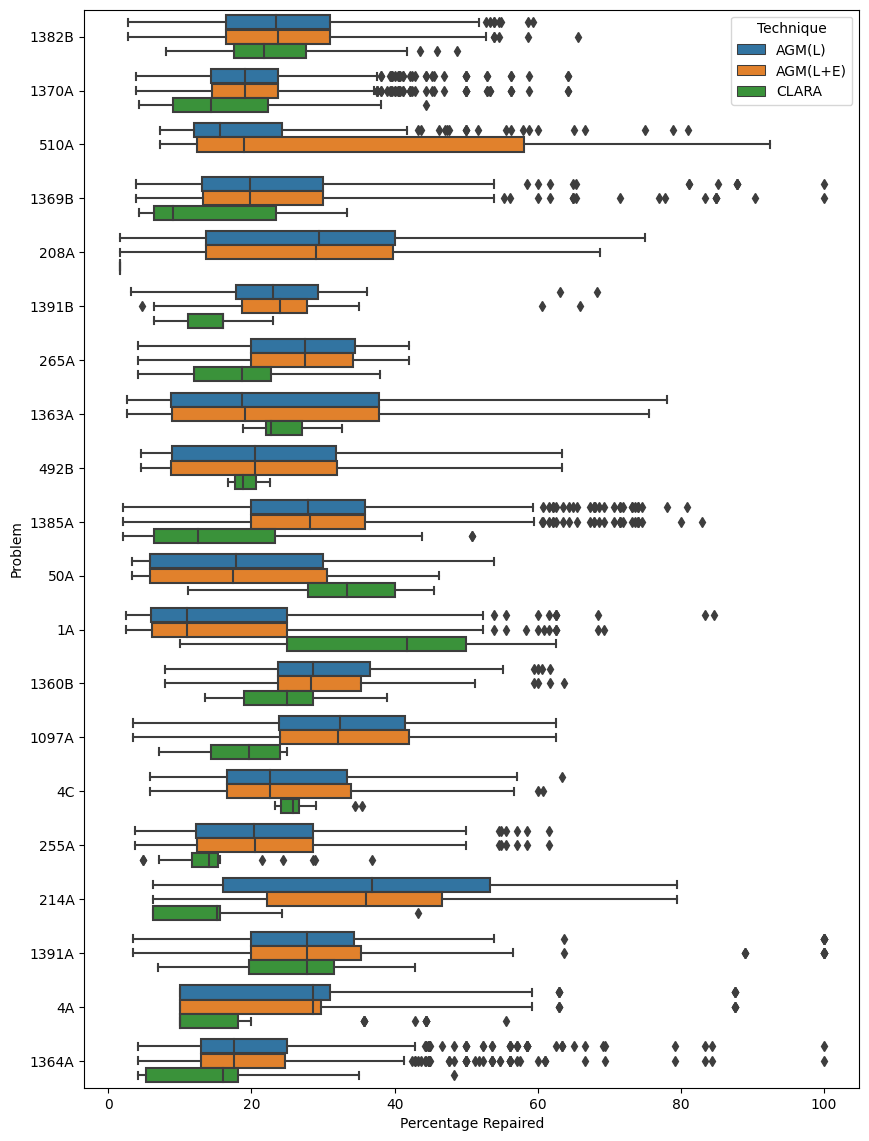

In [18]:
fig = plt.figure(figsize =(10, 14))

ax = sns.boxplot(
    data=filtered, 
    x="Percentage Repaired", 
    hue='Technique', 
    y="Problem",
    orient="h")
# ax.set_title("Percentage Repaired")
ax.set_ylabel("Problem")
ax.set_xlabel("Percentage Repaired")
plt.show()
# plt.savefig("problems_percentage_repaired.png", format='png')

In [33]:
# Lines of code
filtered.groupby('Problem')['Correct File', 'Incorrect File'].describe()
# Lines of code
filtered.groupby('Problem')['Correct Locs'].describe()
# Exprs
filtered.groupby('Problem')['Correct Exprs'].describe()

/tmp/ipykernel_2725/4035063900.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  filtered.groupby('Problem')['Correct File', 'Incorrect File'].describe()


Correct File                         Incorrect File                    \
               count unique        top  freq          count unique        top   
Problem                                                                         
1097A           1329     10   47914034   174           1329     72   86317745   
1360B            544      4   81262344   247            544     85   81273134   
1363A           2788      7   94360372   628           2788    295   82104304   
1364A          12581     11   88676701  1899          12581    679   83641542   
1369B           2410      7   84818849   564           2410    211  130464987   
1370A           3012      6   84937818   675           3012    249   85245781   
1382B           1532      5  127317965   383           1532    145   87634013   
1385A           4779      6   87130898  1215           4779    428  107699957   
1391A           9033     25  111547833   438           9033    148   89444614   
1391B            318      6   89437272   126            318     51   89556835   
1A               877      5  135422761   313            877    125   86749291   
208A             447      5  147767486   183            447     65   98278204   
214A             717      7   71945352   183            717     66   71945270   
255A            1856     12  105582002   270           1856     96   81330953   
265A             300      6   84938064    69            300     25   89989245   
492B            1147      9   93955115   246           1147     90   25659571   
4A              1059     10   88235641   129           1059     43  124610772   
4C              1107     10  125900459   198           1107     66  108168613   
50A              567      5   68121636   168            567     60   35104803   
510A            1001      7   18717839   198           1001     78  105048445   

              
        freq  
Problem       
1097A     27  
1360B     12  
1363A     21  
1364A     33  
1369B     21  
1370A     18  
1382B     15  
1385A     18  
1391A     75  
1391B     15  
1A        12  
208A      15  
214A      21  
255A      30  
265A      15  
492B      24  
4A        30  
4C        30  
50A       15  
510A      21

In [90]:
# Successfully repaired out of all the incorrect numbers
print('Number of failed repairs')
display(clara.groups_analyze(df=filtered[filtered['Repairs'].isna()==True], columns=['Technique']))
print('Number of successful repairs')
display(clara.groups_analyze(df=filtered[filtered['Repairs'].isna()!=True], columns=['Technique']))
print('Number of total repairs')
display(clara.groups_analyze(df=filtered, columns=['Technique']))

# 
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique', 'Problem'])['Problem'].count()\
        /filtered.groupby(['Technique', 'Problem'])['Problem'].count())
display(repaired_tech_problem.values)
display(repaired_tech_problem.index)

Number of failed repairs


,Technique
Technique,
AGM(L),8546
AGM(L+E),8485
CLARA,15163


Number of successful repairs


,Technique
Technique,
AGM(L),7184
AGM(L+E),7264
CLARA,762


Number of total repairs


,Technique
Technique,
AGM(L),15730
AGM(L+E),15749
CLARA,15925


Technique
AGM(L)      0.456707
AGM(L+E)    0.461236
CLARA       0.047849
Name: Problem, dtype: float64

array([0.23024831, 0.93370166, 0.90769231, 0.21143267, 0.6218593 ,
       0.75398406, 0.79411765, 0.48015123, 0.34805712, 0.77227723,
       0.96864111, 0.63758389, 0.18565401, 0.42394822, 0.79      ,
       0.36339523, 0.66572238, 0.50413223, 0.97354497, 0.48348348,
       0.23356009, 0.9281768 , 0.90679825, 0.21251194, 0.62625   ,
       0.7559761 , 0.79371316, 0.48017621, 0.34905347, 0.77669903,
       0.97560976, 0.63087248, 0.20083682, 0.42139384, 0.79      ,
       0.36675462, 0.68838527, 0.50824176, 0.96296296, 0.62275449,
       0.01348315, 0.18131868, 0.00621118, 0.01092118, 0.01351351,
       0.11752988, 0.17153996, 0.01996257, 0.0554633 , 0.04385965,
       0.12541254, 0.00671141, 0.0373444 , 0.03542673, 0.38      ,
       0.00767263, 0.25495751, 0.03947368, 0.17989418,        nan])

MultiIndex([(  'AGM(L)', '1097A'),
            (  'AGM(L)', '1360B'),
            (  'AGM(L)', '1363A'),
            (  'AGM(L)', '1364A'),
            (  'AGM(L)', '1369B'),
            (  'AGM(L)', '1370A'),
            (  'AGM(L)', '1382B'),
            (  'AGM(L)', '1385A'),
            (  'AGM(L)', '1391A'),
            (  'AGM(L)', '1391B'),
            (  'AGM(L)',    '1A'),
            (  'AGM(L)',  '208A'),
            (  'AGM(L)',  '214A'),
            (  'AGM(L)',  '255A'),
            (  'AGM(L)',  '265A'),
            (  'AGM(L)',  '492B'),
            (  'AGM(L)',    '4A'),
            (  'AGM(L)',    '4C'),
            (  'AGM(L)',   '50A'),
            (  'AGM(L)',  '510A'),
            ('AGM(L+E)', '1097A'),
            ('AGM(L+E)', '1360B'),
            ('AGM(L+E)', '1363A'),
            ('AGM(L+E)', '1364A'),
            ('AGM(L+E)', '1369B'),
            ('AGM(L+E)', '1370A'),
            ('AGM(L+E)', '1382B'),
            ('AGM(L+E)', '1385A'),
            ('AGM(L+

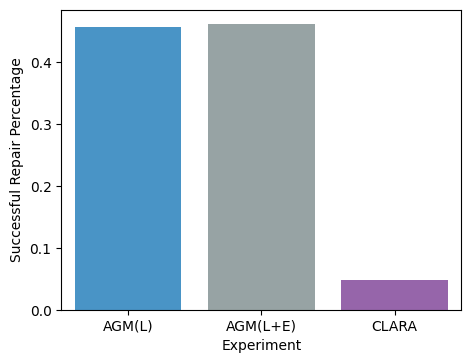

In [89]:
fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_techniques.index, y=repaired_techniques.values, ax=ax, palette=palette)
ax.set_ylabel("Successful Repair Percentage")
ax.set_xlabel("Experiment")
plt.savefig('successful_repair_by_experiment.pdf', format="pdf", bbox_inches='tight')

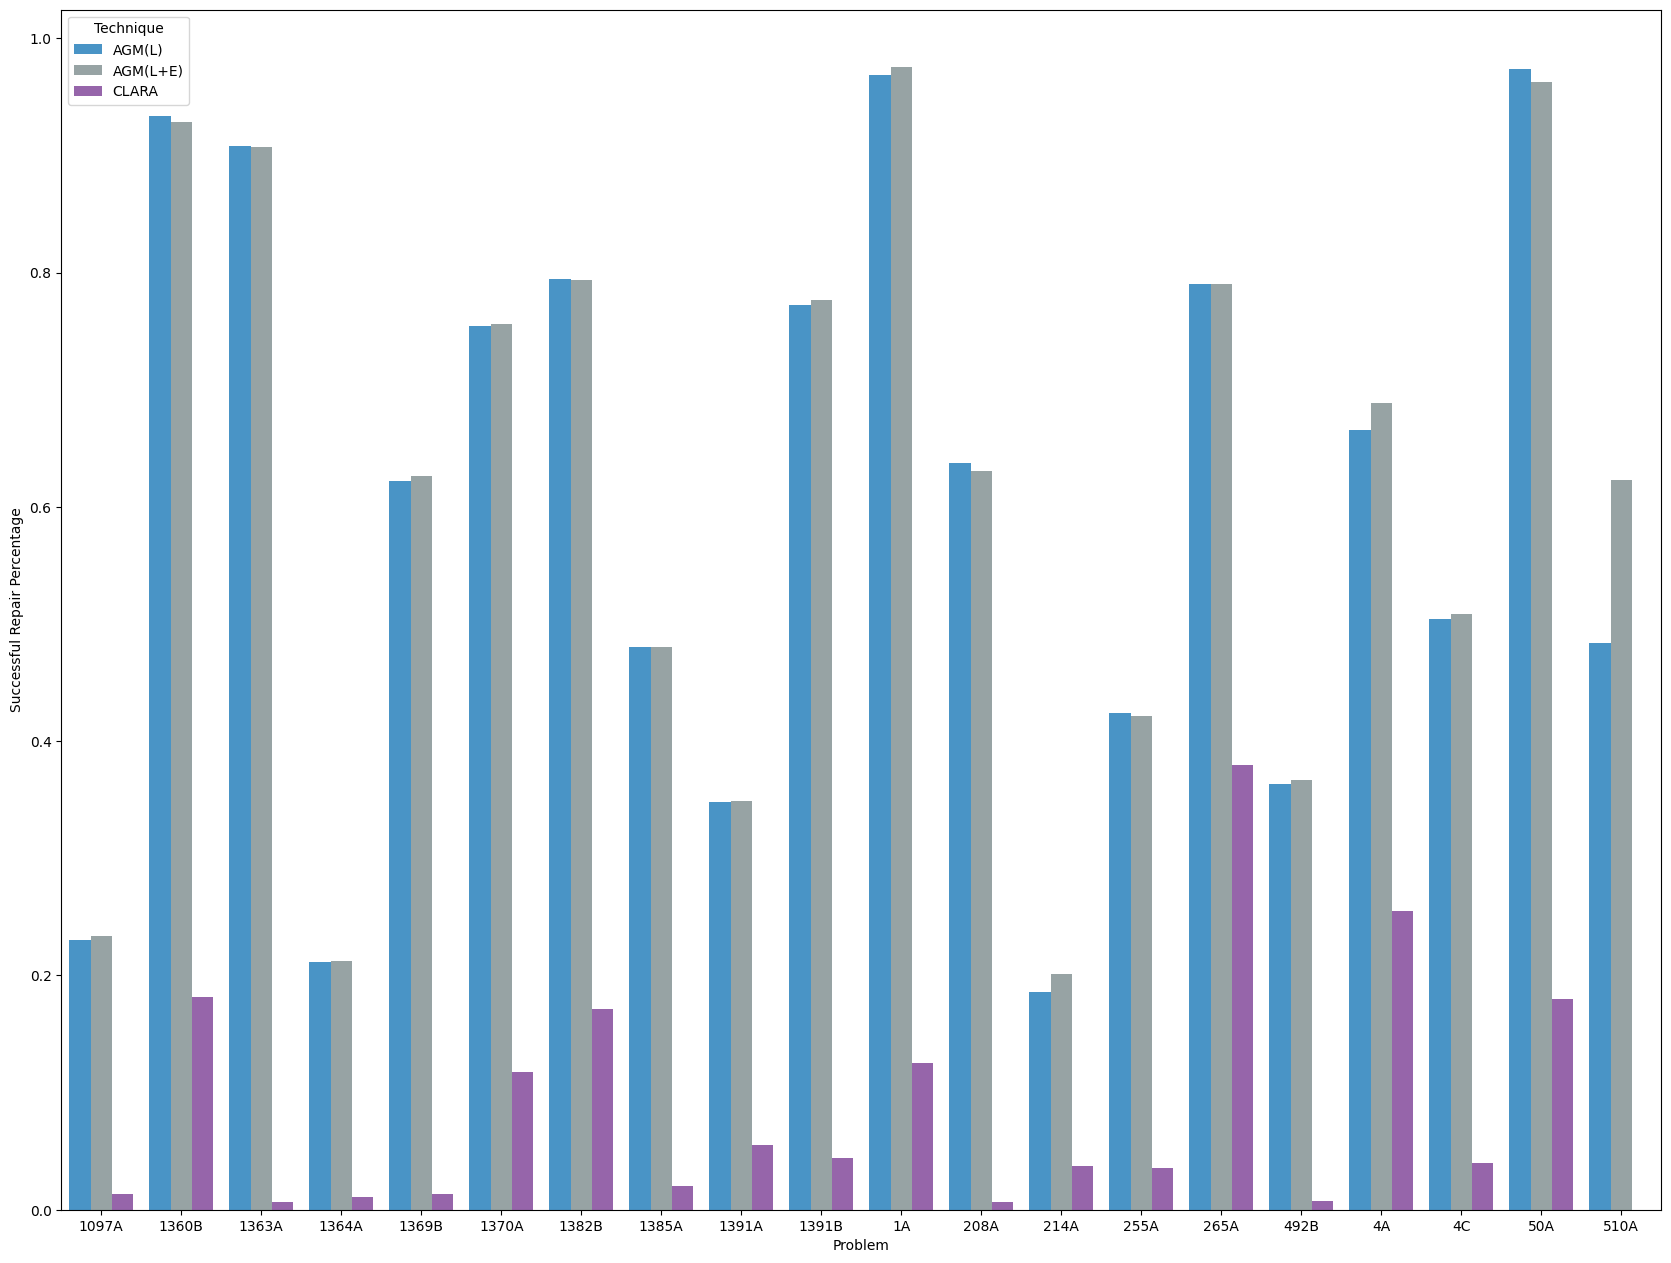

In [91]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_tech_problem.index.get_level_values('Problem'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values, ax=ax, palette=palette)
ax.set_ylabel("Successful Repair Percentage")
ax.set_xlabel("Problem")
plt.savefig('successful_repair_by_problem.pdf', format="pdf", bbox_inches='tight')

In [92]:
filtered['locs_bin'] = pd.cut(np.array(filtered['Correct Locs']), bins=[0,10,20,30,40,50,60,70,80])
filtered[filtered['locs_bin'].isna() != True]['Correct File']
def add_locs_bin(x, filtered):
    row = filtered.loc[(filtered['locs_bin'].isna() != True)]
    row = row[row['Correct File'] == x['Correct File']]
    if len(row['locs_bin']) > 0:
        x['locs_bin'] = row['locs_bin'].iloc[0]
    return x
filtered = filtered.apply(lambda x: add_locs_bin(x, filtered), axis=1)

Technique
AGM(L)      0.456707
AGM(L+E)    0.461236
CLARA       0.047849
Name: Problem, dtype: float64

array([0.90145462, 0.88560886, 0.93535749, 0.61538462, 0.8852459 ,
       0.04081633, 0.17073171, 0.90490798, 0.89879392, 0.95592556,
       0.59615385, 0.87903226, 0.02040816, 0.20512821, 0.12312677,
       0.05840886, 0.03550864, 0.01923077,        nan,        nan,
              nan])

MultiIndex([(  'AGM(L)',  (0.0, 10.0]),
            (  'AGM(L)', (10.0, 20.0]),
            (  'AGM(L)', (20.0, 30.0]),
            (  'AGM(L)', (30.0, 40.0]),
            (  'AGM(L)', (40.0, 50.0]),
            (  'AGM(L)', (50.0, 60.0]),
            (  'AGM(L)', (70.0, 80.0]),
            ('AGM(L+E)',  (0.0, 10.0]),
            ('AGM(L+E)', (10.0, 20.0]),
            ('AGM(L+E)', (20.0, 30.0]),
            ('AGM(L+E)', (30.0, 40.0]),
            ('AGM(L+E)', (40.0, 50.0]),
            ('AGM(L+E)', (50.0, 60.0]),
            ('AGM(L+E)', (70.0, 80.0]),
            (   'CLARA',  (0.0, 10.0]),
            (   'CLARA', (10.0, 20.0]),
            (   'CLARA', (20.0, 30.0]),
            (   'CLARA', (30.0, 40.0]),
            (   'CLARA', (40.0, 50.0]),
            (   'CLARA', (50.0, 60.0]),
            (   'CLARA', (70.0, 80.0])],
           names=['Technique', 'locs_bin'])

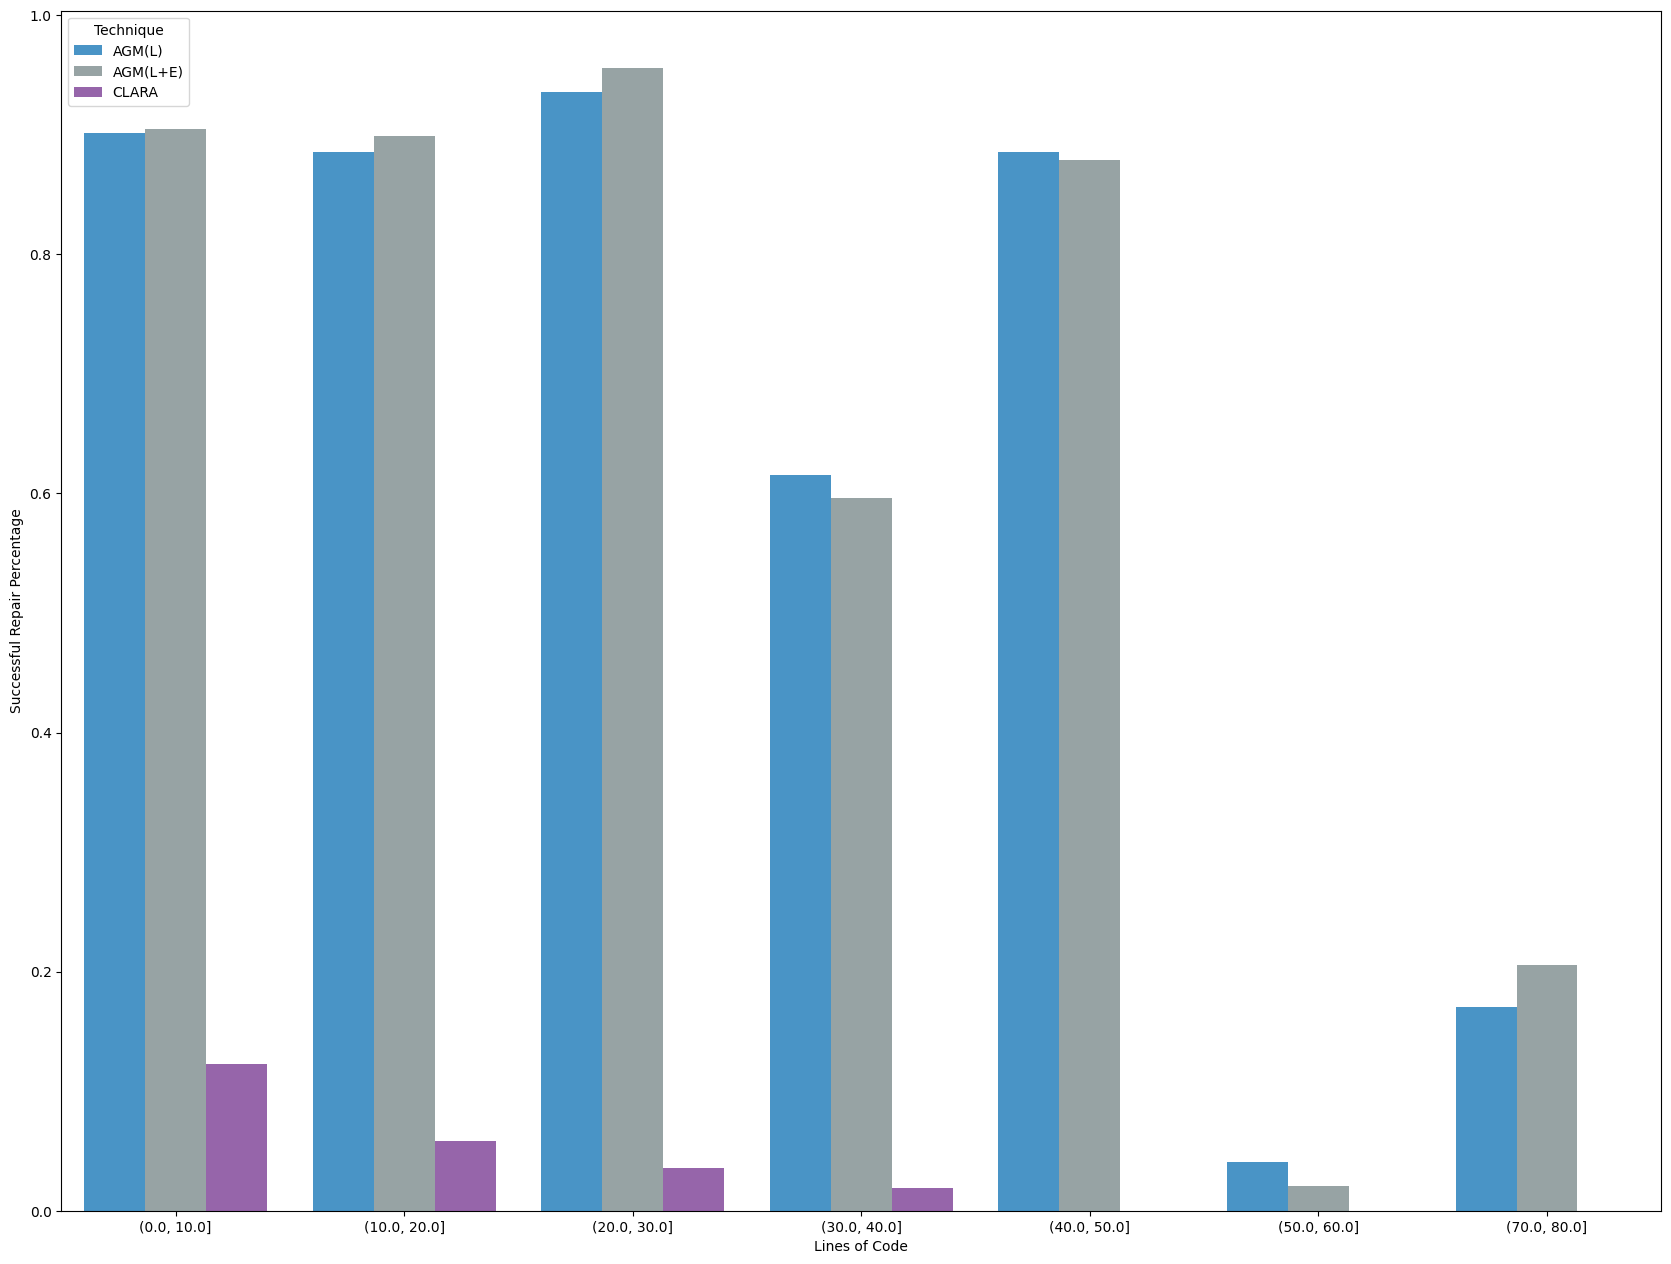

In [93]:
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique', 'locs_bin'])['Problem'].count()\
        /filtered.groupby(['Technique', 'locs_bin'])['Problem'].count())
display(repaired_tech_problem.values)
display(repaired_tech_problem.index)

fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_tech_problem.index.get_level_values('locs_bin'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values, ax=ax, palette=palette)
ax.set_ylabel("Successful Repair Percentage")
ax.set_xlabel("Lines of Code")
plt.savefig('successful_repair_by_loc.pdf', format="pdf", bbox_inches='tight')

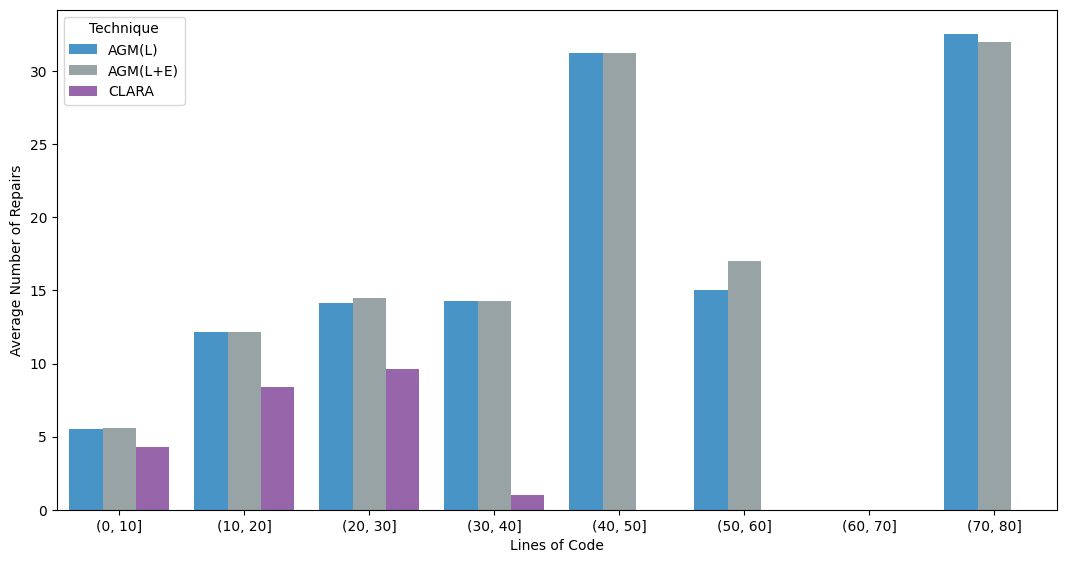

In [94]:
filtered['locs_bin'] = pd.cut(np.array(filtered['Correct Locs']), bins=[0,10,20,30,40,50,60,70,80])
locs = filtered.groupby(['locs_bin', 'Technique'])['Repairs'].mean()
# y = np.array(filtered['Repairs'])
# z = np.array(filtered['Technique'])
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("Average Number of Repairs")
ax.set_xlabel("Lines of Code")
plt.savefig('average_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')

Text(0.5, 0, 'Lines of Code')

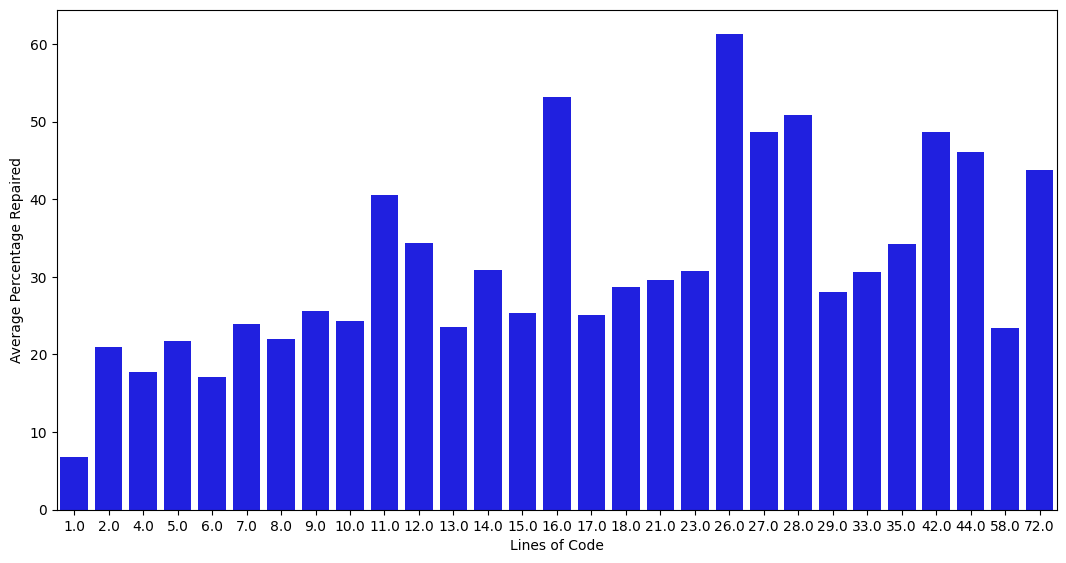

In [27]:
locs = filtered.groupby(['Correct Locs'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index,
            color='blue',
            y=locs.values, ax=ax)
ax.set_ylabel("Average Percentage Repaired")
ax.set_xlabel("Lines of Code")

locs_bin  Technique
(0, 10]   AGM(L)       21.785413
          AGM(L+E)     22.008030
          CLARA        21.815766
(10, 20]  AGM(L)       26.643741
          AGM(L+E)     27.265542
          CLARA        20.863671
(20, 30]  AGM(L)       31.057062
          AGM(L+E)     32.041211
          CLARA        19.430067
(30, 40]  AGM(L)       32.360177
          AGM(L+E)     32.594571
          CLARA         1.562500
(40, 50]  AGM(L)       48.456772
          AGM(L+E)     48.548577
          CLARA              NaN
(50, 60]  AGM(L)       22.388060
          AGM(L+E)     25.373134
          CLARA              NaN
(60, 70]  AGM(L)             NaN
          AGM(L+E)           NaN
          CLARA              NaN
(70, 80]  AGM(L)       43.349420
          AGM(L+E)     44.199826
          CLARA              NaN
Name: Percentage Repaired, dtype: float64

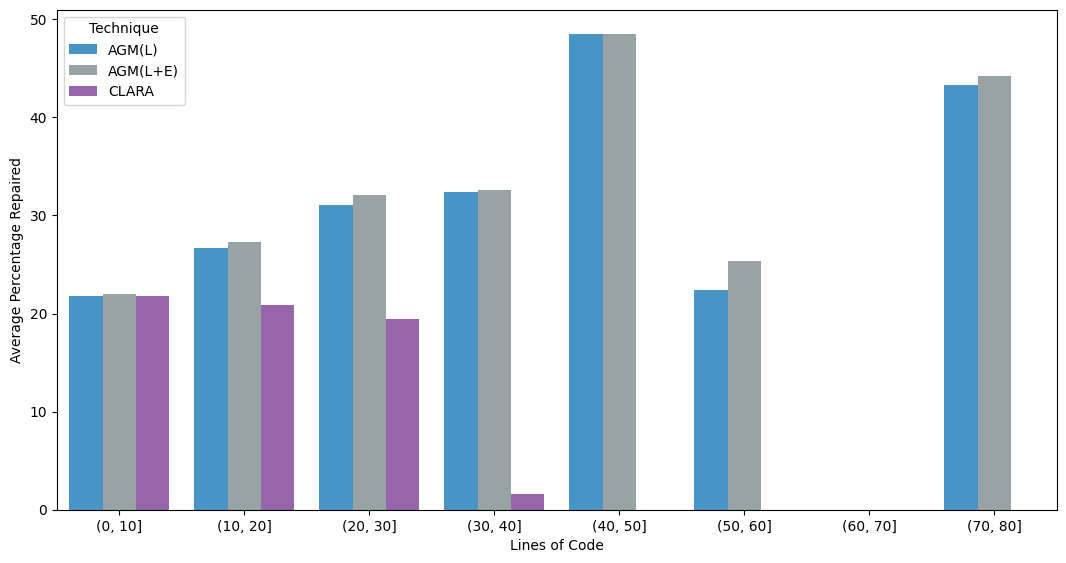

In [97]:
locs = filtered.groupby(['locs_bin', 'Technique'])['Percentage Repaired'].mean()
display(locs)
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("Average Percentage Repaired")
ax.set_xlabel("Lines of Code")
plt.savefig('average_percentage_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')

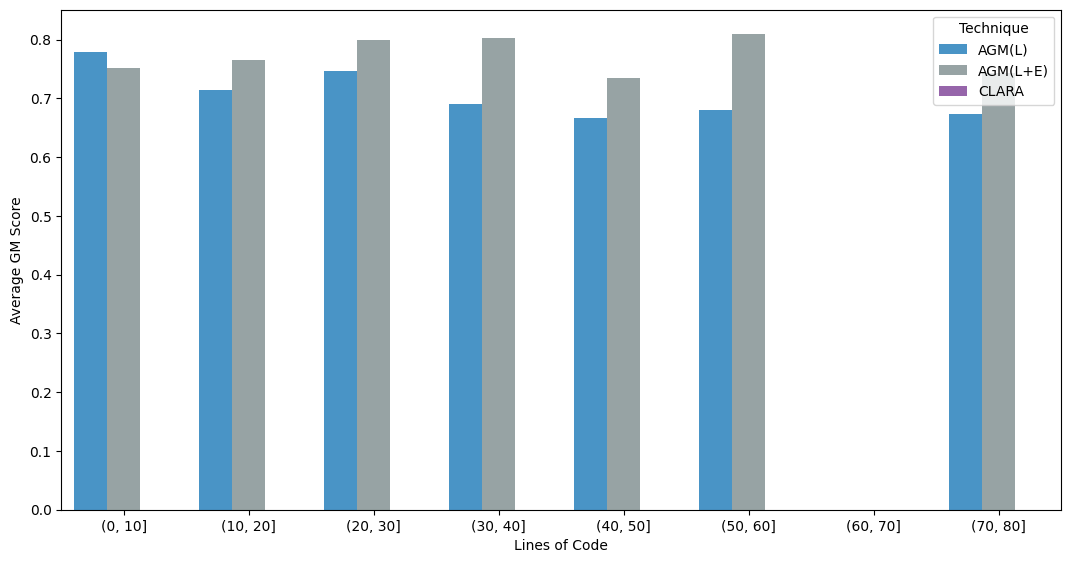

In [102]:
locs = filtered.groupby(['locs_bin', 'Technique'])['GM Score'].mean()
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("Average GM Score")
ax.set_xlabel("Lines of Code")
plt.savefig('average_gm_score_by_loc.pdf', format="pdf", bbox_inches='tight')